<a href="https://colab.research.google.com/github/ranieri-unimi/git.ammagamma/blob/main/lec0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-on time

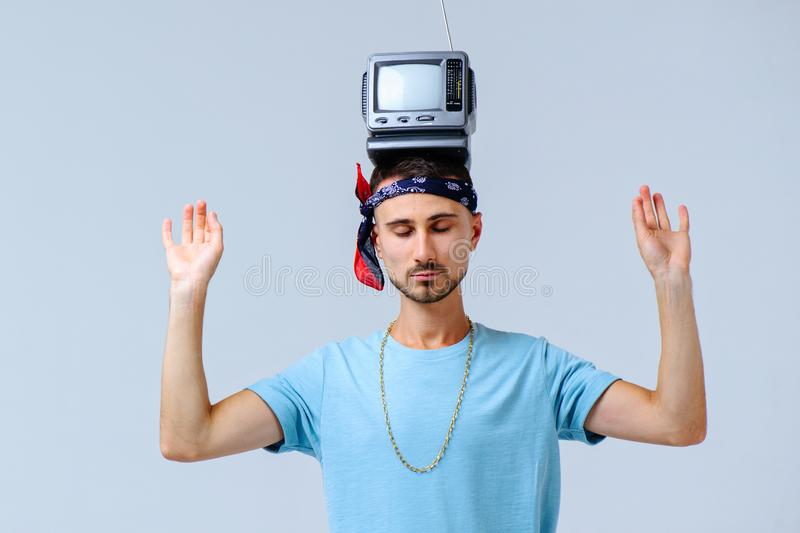

In this lab we'll follow the next steps:
1. Downnload data using Yahoo Finance API
2. Explore and analyze data
3. Learn how to deal with forecasting models - Prophet

In [1]:
# *IMPORT LIBRARIES USED*

!pip install fbprophet
!pip install yfinance

from fbprophet import Prophet
from datetime import date
from scipy import stats
import statsmodels.api as sm
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
from plotly import graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 7.5 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**yfinance**

"Ever since Yahoo! finance decommissioned their historical data API, many programs that relied on it to stop working.

yfinance aimes to solve this problem by offering a reliable, threaded, and Pythonic way to download historical market data from Yahoo! finance."

https://pypi.org/project/yfinance/

# 1. Download data 

Definition of an analysis starting and ending period

In [2]:
start = pd.to_datetime('2010-01-01')
end = date.today()
#custom_end = pd.to_datetime('2022-05-22')
#end = custom_end

Definition of a list of Ticker: in yfinance you need to specify the rate needed in the following format:  't_currency1t_currency2=X'.

In [3]:
# In yfinance
tickers_to_download = ['EURUSD=X', 'GBPUSD=X', 'USDCHF=X', 'USDJPY=X', 'EURJPY=X', 'USDCAD=X', 'AUDUSD=X']

Download the previous tickers only for Close prices

In [4]:
forex_df_list = []

for ticker in tickers_to_download:
  ts = yf.download(ticker, start, end)['Close']
  ts = ts.rename(ticker.lower().split('=', 1)[0] + '_close')
  forex_df_list.append(ts)

forex_df = pd.concat(forex_df_list, axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
forex_df

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  \
Date                                                                 
2010-01-01      1.438994      1.613294       1.03390     92.919998   
2010-01-04      1.442398      1.611370       1.02910     92.495003   
2010-01-05      1.436596      1.599079       1.03370     91.584999   
2010-01-06      1.440403      1.602384       1.02760     92.356003   
2010-01-07      1.431803      1.593397       1.03360     93.389999   
...                  ...           ...           ...           ...   
2022-05-20      1.057899      1.246215       0.97218    127.832001   
2022-05-23      1.056982      1.250406       0.97499    127.903000   
2022-05-24      1.068205      1.256755       0.96595    127.846001   
2022-05-25      1.073653      1.254296       0.96020    126.768997   
2022-05-26      1.071926      1.257261       0.95934    127.084999   

            eurjpy_close  usdcad_close  audusd_close  
Date                                                  
2010-01-01    133.710007       1.05120      0.898473  
2010-01-04    133.389999       1.04100      0.912492  
2010-01-05    131.529999       1.03950      0.911826  
2010-01-06    133.013000       1.03190      0.920471  
2010-01-07    133.748001       1.03400      0.917768  
...                  ...           ...           ...  
2022-05-20    135.220993       1.28196      0.704150  
2022-05-23    135.182999       1.28120      0.706289  
2022-05-24    136.559006       1.27871      0.708898  
2022-05-25    136.061996       1.28224      0.710320  
2022-05-26    136.201996       1.28040      0.709019  

[3233 rows x 7 columns]

# 2. Data exploration

### Check missing values and fill if needed

In [6]:
# nan values do exist
forex_df[forex_df.isnull().any(axis=1)]

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  \
Date                                                                 
2011-04-15      1.443210           NaN           NaN           NaN   
2012-01-27      1.309278      1.568209           NaN     77.459999   
2012-01-31      1.313957      1.570845           NaN     76.360001   
2012-12-04           NaN      1.609787           NaN     82.133003   
2013-10-08           NaN           NaN           NaN           NaN   
2019-05-22           NaN           NaN           NaN           NaN   

            eurjpy_close  usdcad_close  audusd_close  
Date                                                  
2011-04-15           NaN           NaN           NaN  
2012-01-27    101.421997        1.0024      1.061582  
2012-01-31    100.330002        1.0024      1.058604  
2012-12-04    107.301003           NaN           NaN  
2013-10-08    131.289993           NaN           NaN  
2019-05-22    123.438004           NaN           NaN

Multiple strategies can be used to fill missing values, these depend on the nature of the problem (but be aware of the consequences):

- use median, mode, mean values
- use a statistical method: regression, nearest neighbors
- back/forward fill, **interpolate**
- drop missing data 

In [7]:
# fillna fills with given value or method: in this case forward fill
forex_df.fillna(method='ffill', axis=0).loc['2011-04-15']

eurusd_close      1.443210
gbpusd_close      1.626889
usdchf_close      0.895900
usdjpy_close     83.782997
eurjpy_close    121.000000
usdcad_close      0.962600
audusd_close      1.049803
Name: 2011-04-15 00:00:00, dtype: float64

In [8]:
forex_df.loc['2011-04-14']

eurusd_close      1.444210
gbpusd_close      1.626889
usdchf_close      0.895900
usdjpy_close     83.782997
eurjpy_close    121.000000
usdcad_close      0.962600
audusd_close      1.049803
Name: 2011-04-14 00:00:00, dtype: float64

In [9]:
# interpolate interpolates given a method
forex_df.interpolate(method='linear', axis=0).loc['2011-04-15']

eurusd_close      1.443210
gbpusd_close      1.629145
usdchf_close      0.894250
usdjpy_close     83.465000
eurjpy_close    120.417999
usdcad_close      0.961300
audusd_close      1.053002
Name: 2011-04-15 00:00:00, dtype: float64

In [10]:
forex_df.loc[['2011-04-14', '2011-04-15', '2011-04-18']]

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  \
Date                                                                 
2011-04-14      1.444210      1.626889        0.8959     83.782997   
2011-04-15      1.443210           NaN           NaN           NaN   
2011-04-18      1.441296      1.631401        0.8926     83.147003   

            eurjpy_close  usdcad_close  audusd_close  
Date                                                  
2011-04-14    121.000000        0.9626      1.049803  
2011-04-15           NaN           NaN           NaN  
2011-04-18    119.835999        0.9600      1.056201

In [11]:
# let's use interpolation since we are dealing with time series data
forex_df.interpolate(method='linear', axis=0, inplace=True)
# double check on missing data
forex_df[forex_df.isnull().any(axis=1)]

Empty DataFrame
Columns: [eurusd_close, gbpusd_close, usdchf_close, usdjpy_close, eurjpy_close, usdcad_close, audusd_close]
Index: []

In [12]:
forex_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3233 entries, 2010-01-01 to 2022-05-26
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   eurusd_close  3233 non-null   float64
 1   gbpusd_close  3233 non-null   float64
 2   usdchf_close  3233 non-null   float64
 3   usdjpy_close  3233 non-null   float64
 4   eurjpy_close  3233 non-null   float64
 5   usdcad_close  3233 non-null   float64
 6   audusd_close  3233 non-null   float64
dtypes: float64(7)
memory usage: 331.1 KB


In [13]:
forex_df.describe()

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  eurjpy_close  \
count   3233.000000   3233.000000   3233.000000   3233.000000   3233.000000   
mean       1.215814      1.445151      0.954950    102.979985    124.078987   
std        0.108296      0.142311      0.051085     13.376851     10.915264   
min        1.037958      1.149439      0.722800     75.739998     94.209999   
25%        1.122385      1.309929      0.919440     93.419998    117.239998   
50%        1.185255      1.441940      0.958300    107.166000    125.665001   
75%        1.313198      1.571981      0.988160    111.811996    131.778000   
max        1.484406      1.716090      1.162700    130.811005    149.440994   

       usdcad_close  audusd_close  
count   3233.000000   3233.000000  
mean       1.191873      0.830419  
std        0.140199      0.127578  
min        0.943200      0.574290  
25%        1.033170      0.726797  
50%        1.254400      0.772380  
75%        1.313600      0.935979  
max        1.457800      1.103497

### Visualize data

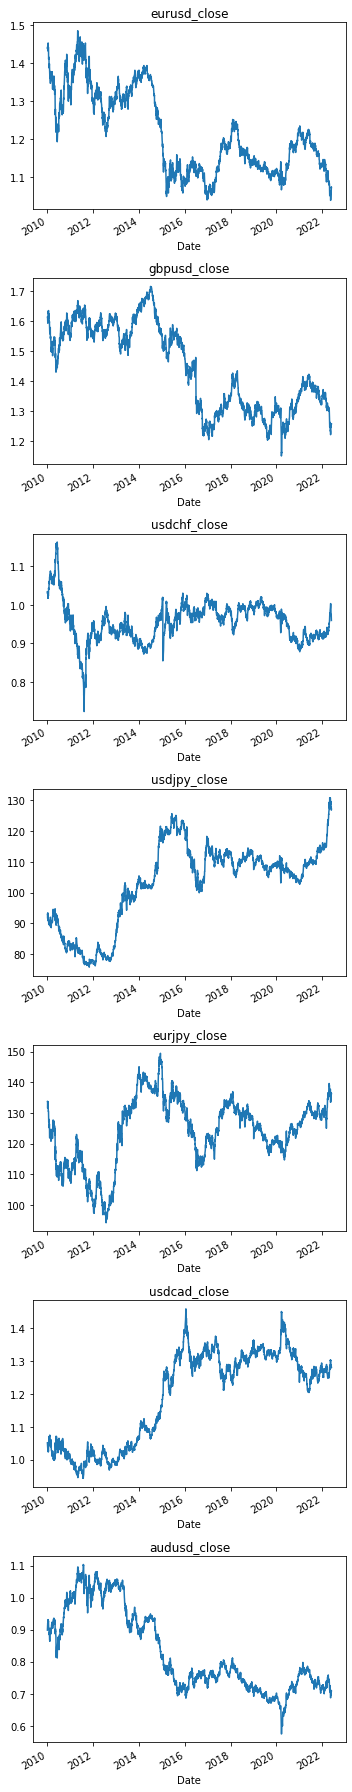

In [14]:
fig, ax = plt.subplots(forex_df.shape[1],1, figsize=(5,25))
for idx, col in enumerate(forex_df):
  forex_df[col].plot(ax=ax[idx])
  ax[idx].set_title(col)
fig.tight_layout()

In [15]:
# Looking for something fancier? go for plotly :-)

for idx, col in enumerate(forex_df):
  fig = px.line(forex_df, y=col)
  fig.show()

Scaling the changes using by percentange change, in order to remove differences between pricing, scaling is also vital to perform the Value at Risk calculation and for a statistical analysis.

1. For risk analysis we are more interested in daily changes than in the absolute value of the rate. (e.g. for VaR analysis)

In [16]:
forex_rate_df = forex_df.pct_change(axis='rows')
forex_rate_df_clean = forex_rate_df.dropna(axis=0)

In [17]:
# New Dataframe cleaned
forex_rate_df_clean

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  \
Date                                                                 
2010-01-04      0.002366     -0.001192     -0.004643     -0.004574   
2010-01-05     -0.004022     -0.007628      0.004470     -0.009838   
2010-01-06      0.002650      0.002067     -0.005901      0.008418   
2010-01-07     -0.005971     -0.005609      0.005839      0.011196   
2010-01-08      0.006499      0.005657     -0.009675     -0.007817   
...                  ...           ...           ...           ...   
2022-05-20      0.010145      0.009421     -0.015155     -0.000641   
2022-05-23     -0.000867      0.003364      0.002890      0.000555   
2022-05-24      0.010618      0.005077     -0.009272     -0.000446   
2022-05-25      0.005100     -0.001957     -0.005953     -0.008424   
2022-05-26     -0.001608      0.002364     -0.000896      0.002493   

            eurjpy_close  usdcad_close  audusd_close  
Date                                                  
2010-01-04     -0.002393     -0.009703      0.015604  
2010-01-05     -0.013944     -0.001441     -0.000729  
2010-01-06      0.011275     -0.007311      0.009481  
2010-01-07      0.005526      0.002035     -0.002937  
2010-01-08     -0.001929     -0.004062      0.007956  
...                  ...           ...           ...  
2022-05-20      0.009474     -0.005014      0.011855  
2022-05-23     -0.000281     -0.000593      0.003038  
2022-05-24      0.010179     -0.001944      0.003693  
2022-05-25     -0.003640      0.002761      0.002006  
2022-05-26      0.001029     -0.001435     -0.001832  

[3232 rows x 7 columns]

Aggregated Returns plot 

In [18]:
fig = go.Figure()

for ticker in forex_rate_df_clean.columns:

  # Only thing I figured is - I could do this 
  fig.add_scatter(
                  x=forex_rate_df_clean.index,
                  y=forex_rate_df_clean[f'{ticker}'],
                  name=f'{ticker}'
                ) # Not what is desired - need a line 

# Show plot 
fig.show()

### Standard Deviation of the different rates of returns.

In [19]:
for ticker in forex_rate_df_clean.columns:
  fig = px.histogram(forex_rate_df_clean, x=ticker,
                    marginal="rug", template="plotly_white",
                    hover_data=forex_rate_df_clean.columns, 
                    title=f'Distribution of {ticker} the std related to it is {np.round(forex_rate_df_clean[ticker].std(), 3)}')
  fig.show()

Correlation analysis between numerical variables. 

In [20]:
fig = px.scatter_matrix(forex_rate_df_clean,
                        dimensions=forex_rate_df_clean.columns.to_list(),
                        height=1000, width=1000, 
                        template='plotly_white'
                        )

fig.update_traces(diagonal_visible=False)
fig.show()

### Pearson Correlation

Text(0.5, 1.0, 'Correlation Heatmap')

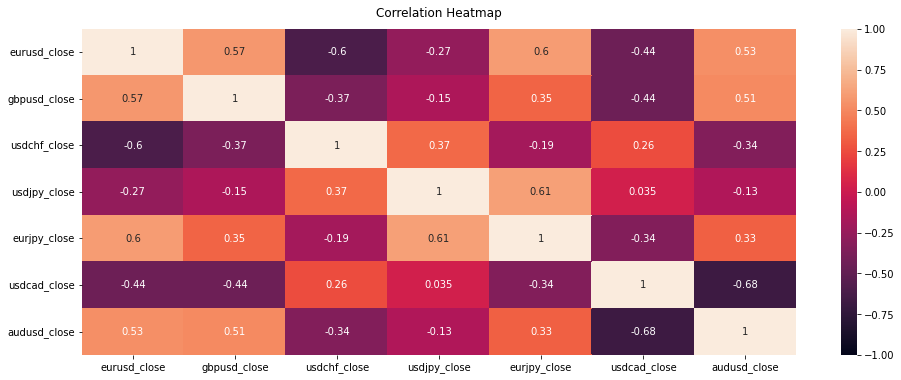

In [21]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(forex_rate_df_clean.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

# Homework :-)

- Can you compute the following Risk Measures per each exchange rate?
  - MDD
  - VaR (99%): historical method and through the estimation of the probability distribution.
  - Expected Shortfall (90%)


In [33]:
from datetime import date
ds = forex_df.eurusd_close#.rolling('28d').sum()

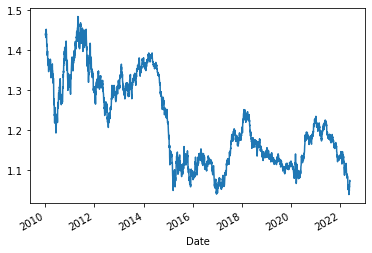

In [36]:
for i in ds.index:
  

In [ ]:
ds.iloc